In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle as shf
import tensorflow as tf

import imgaug as ia
from imgaug import augmenters as iaa

2023-05-14 19:49:14.673623: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 19:49:14.690269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-14 19:49:14.773804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-14 19:49:14.774252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 19:49:15.691713: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Import files

In [ ]:
  def load_data(folder , max_elements=None):
    path = os.path.join("input", folder)
    if not os.path.exists(path):
        print(f"Error: Folder '{folder}' does not exist.")
        return None

    files = os.listdir(path)
    if len(files) == 0:
        print(f"Error: No files found in folder '{folder}'.")
        return None

    if max_elements is not None:
        files = files[:max_elements]

    data = []
    num_processed = 0
    num_total = len(files)
    for file in files:
        if file != '.DS_Store':
            img_path = os.path.join(path, file)
            img = cv2.imread(img_path)
            print(img)
            img = cv2.resize(img, (224, 224))
            img = img.astype('float32') / 255.0

            data.append(img)
            
            num_processed += 1
            print(f"Processed image {num_processed}/{num_total}")
    return np.array(data)

In [ ]:
max_elements_to_train = random.randint(50, 60)
max_elements_to_test = random.randint(40, 50)
max_elements_to_val = random.randint(0, 20)

In [ ]:
train_normal = load_data('train/NORMAL', max_elements_to_train )
train_pneumonia = load_data('train/PNEUMONIA', max_elements_to_train)

test_normal = load_data('test/NORMAL', max_elements_to_test)
test_pneumonia = load_data('test/PNEUMONIA', max_elements_to_test)
    
val_normal = load_data('val/NORMAL', max_elements_to_val)
val_pneumonia = load_data('val/PNEUMONIA',max_elements_to_val)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [4 4 4]
  [1 1 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [2 2 2]
  [2 2 2]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Processed image 1/59
[[[ 0  0  0]
  [85 85 85]
  [85 85 85]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [85 85 85]
  [85 85 85]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  1]
  [86 86 86]
  [84 84 84]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
Processed image 2/59
[[[ 0  0  0]
  [77 77 

### Visualisation

In [ ]:
def visualize_data(normal_data, pneumonia_data):
    if normal_data is None or pneumonia_data is None:
        print("Error: Data is not loaded correctly.")
        return

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    labels = ['Normal', 'Pneumonia']

    for i, data in enumerate([normal_data, pneumonia_data]):
        if data is not None:
            for j, img in enumerate(data[:4]):
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(labels[i])

    plt.tight_layout()
    plt.axis('off')
    plt.show()


In [ ]:
def visualize_data(normal_data, pneumonia_data):
    if normal_data is None or pneumonia_data is None:
        print("Error: Data is not loaded correctly.")
        return

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    labels = ['Normal', 'Pneumonia']

    for i, data in enumerate([normal_data, pneumonia_data]):
        if data is not None:
            for j, img in enumerate(data[:4]):
                axes[i, j].imshow(img, cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(labels[i])

    plt.tight_layout()
    plt.axis('off')
    plt.show()


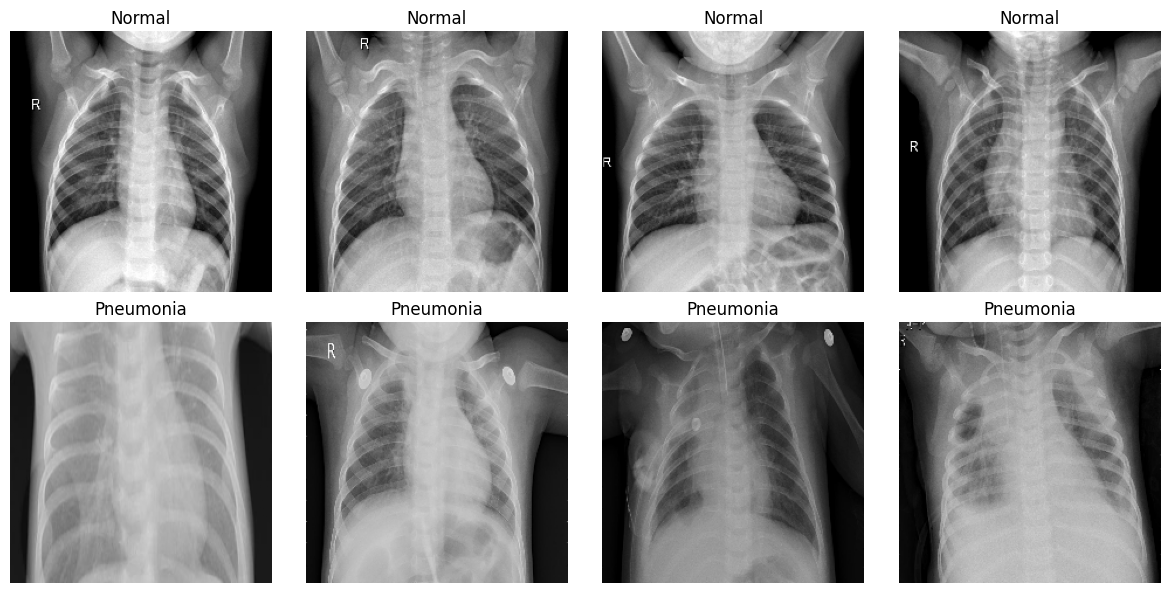

In [ ]:
# Visualize training data
visualize_data(train_normal, train_pneumonia)

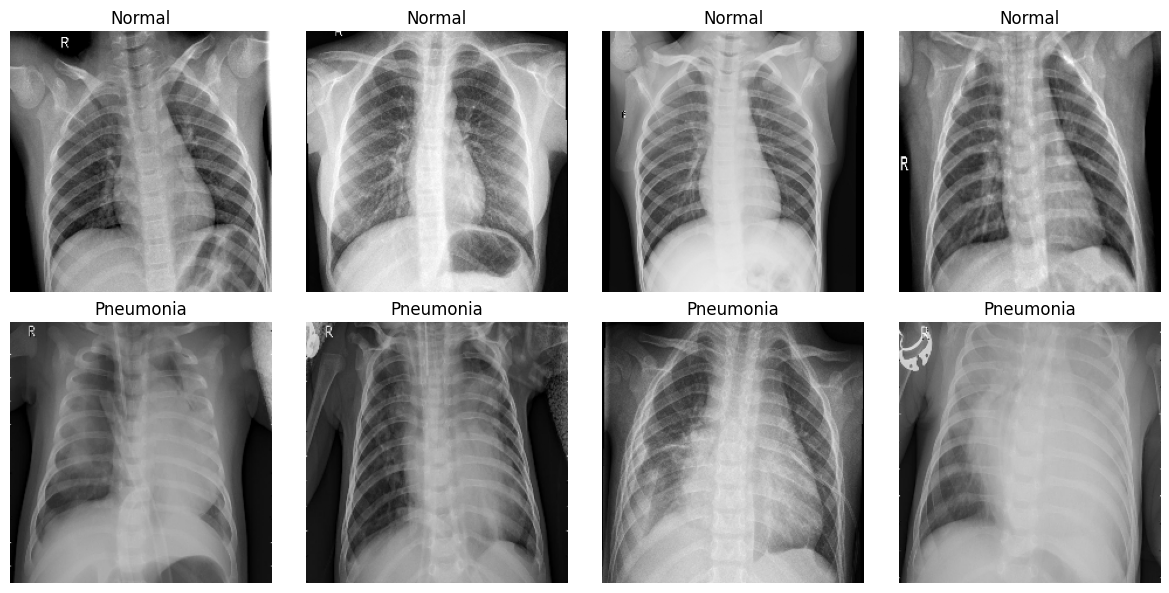

In [ ]:
# Visualize test data
visualize_data(test_normal, test_pneumonia)

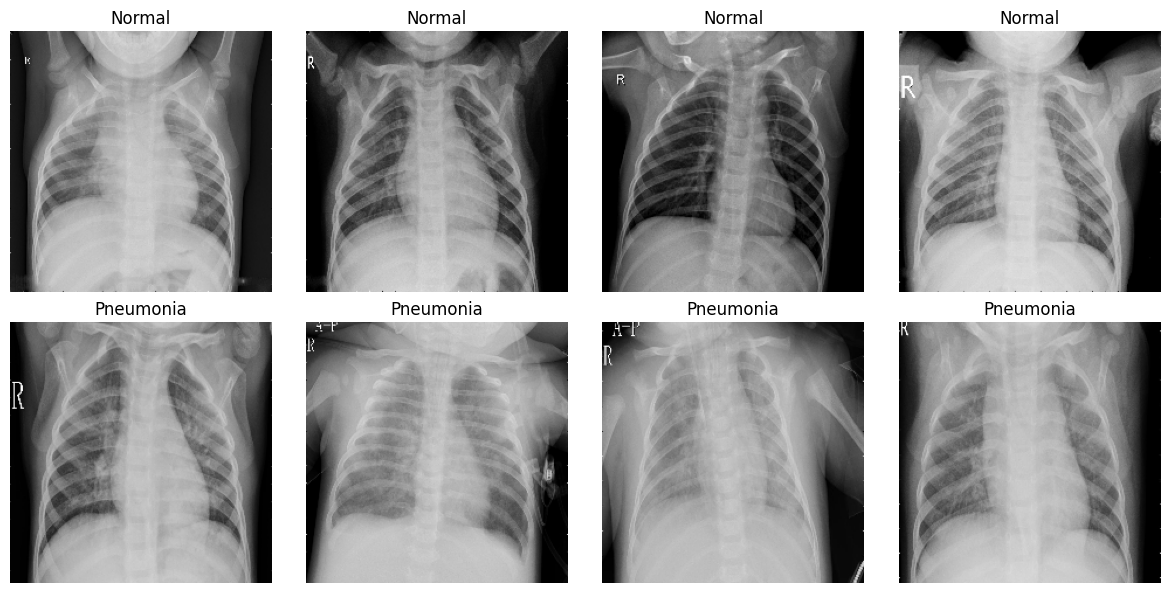

In [ ]:
# Visualize validation data
visualize_data(val_normal, val_pneumonia)

In [ ]:
def visualize_data_distribution(train_normal, train_pneumonia, dossier):
    if train_normal is None or train_pneumonia is None:
        print("Error: Data is not loaded correctly.")
        return

    num_normal = len(train_normal)
    num_pneumonia = len(train_pneumonia)

    labels = ['Normal', 'Pneumonia']

    counts = [num_normal, num_pneumonia]

    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Number of samples')
    plt.title(f'Visualize {dossier} distribution')
    plt.show()

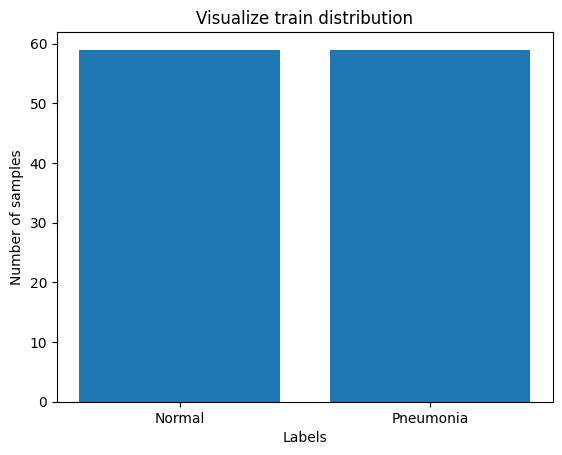

In [ ]:
# Visualize distribution data
visualize_data_distribution(train_normal, train_pneumonia, 'train')

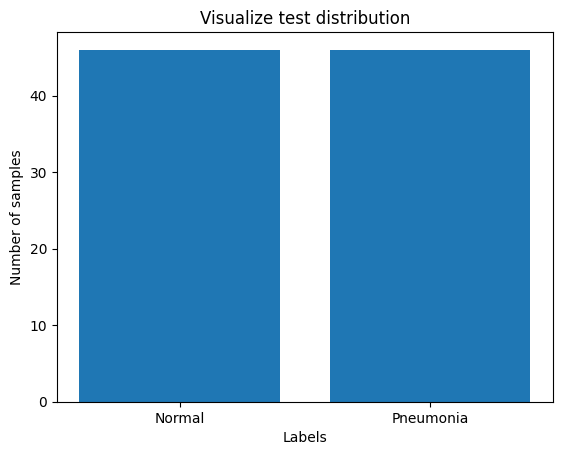

In [ ]:
# Visualize distribution data
visualize_data_distribution(test_normal, test_pneumonia, 'test')

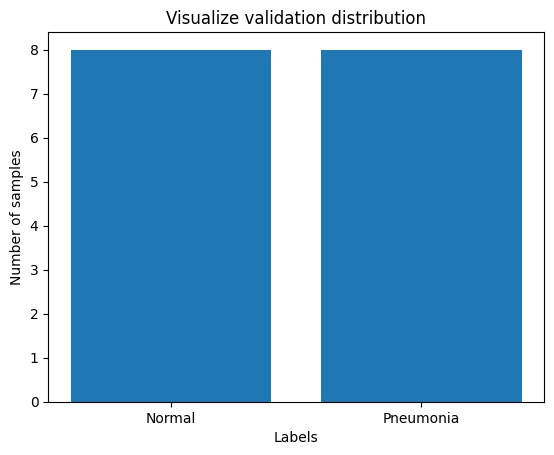

In [ ]:
# Visualize distribution data
visualize_data_distribution(val_normal, val_pneumonia, 'validation')

In [ ]:
X_train = np.concatenate((train_normal, train_pneumonia))
y_train = np.concatenate((np.zeros(train_normal.shape[0]), np.ones(train_pneumonia.shape[0])))

In [ ]:
X_test = np.concatenate((test_normal, test_pneumonia))
y_test = np.concatenate((np.zeros(test_normal.shape[0]), np.ones(test_pneumonia.shape[0])))

In [ ]:
X_val = np.concatenate((val_normal, val_pneumonia))
y_val = np.concatenate((np.zeros(val_normal.shape[0]), np.ones(val_pneumonia.shape[0])))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(118, 224, 224, 3)
(118,)
(16, 224, 224, 3)
(16,)


### Model

In [ ]:
batch_size=64
percent=0.6
learning_rate=0.00001
epochs = 10

random_state= 1
max_iter=100

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn.fit(X_train_flat, y_train)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
# train_losses = []
# val_losses = []
# train_accs = []
# val_accs = []

# for epoch in range(100):
#     print('epoch:', epoch+1, '/100')
#     model.partial_fit(X_train_scaled, y_train, classes=np.unique(y_train))

#     train_predictions = model.predict(X_train_scaled)
#     train_loss = np.mean(train_predictions != y_train)
#     train_losses.append(train_loss)

#     val_predictions = model.predict(X_val_scaled)
#     val_loss = np.mean(val_predictions != y_val)
#     val_losses.append(val_loss)

#     train_acc = model.score(X_train_scaled, y_train)
#     val_acc = model.score(X_val_scaled, y_val)
#     train_accs.append(train_acc)
#     val_accs.append(val_acc)

# fig, ax = plt.subplots(2, 1, figsize=(6, 6))
# ax[0].plot(train_losses, label="TrainLoss")
# ax[0].plot(val_losses, label="ValLoss")
# ax[0].legend(loc='best', shadow=True)

# ax[1].plot(train_accs, label="TrainAcc")
# ax[1].plot(val_accs, label="ValAcc")
# ax[1].legend(loc='best', shadow=True)
# plt.show()


In [ ]:
print('KNN accuracy score is: ' + str(knn.score(X_train_flat, y_train)))

KNN accuracy score is: 0.923728813559322


### Evaluate the model

In [ ]:
predict_out = knn.predict(X_test_flat)
print(y_test, '\n', predict_out)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.]


In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=predict_out)

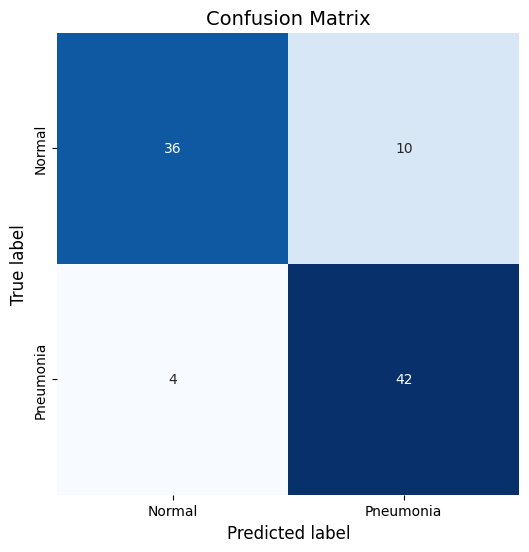

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()